In [27]:
import logging
import re
import time
import copy
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Literal, Optional, Tuple, Union

import numpy as np
from gwpy.timeseries import TimeSeries
import math
from scipy.signal.windows import hann
from scipy.signal import firwin
from scipy.signal import filtfilt
from scipy.signal import resample

import matplotlib.pyplot as plt

In [2]:
PATH_LIKE = Union[str, Path]

patterns = {
    "prefix": "[a-zA-Z0-9_:-]+",
    "start": "[0-9]{10}",
    "duration": "[1-9][0-9]*",
    "suffix": "(gwf)|(hdf5)|(h5)",
}
groups = {k: f"(?P<{k}>{v})" for k, v in patterns.items()}
pattern = "{prefix}-{start}-{duration}.{suffix}".format(**groups)
fname_re = re.compile(pattern)

In [3]:
def parse_frame_name(fname: PATH_LIKE) -> Tuple[str, int, int]:
    """Use the name of a frame file to infer its initial timestamp and length

    Expects frame names to follow a standard nomenclature
    where the name of the frame file ends {prefix}_{timestamp}-{length}.gwf

    Args:
        fname: The name of the frame file
    Returns:
        The prefix of the frame file name
        The initial GPS timestamp of the frame file
        The length of the frame file in seconds
    """

    if isinstance(fname, Path):
        fname = fname.name

    match = fname_re.search(fname)
    if match is None:
        raise ValueError(f"Could not parse frame filename {fname}")

    prefix, start, duration, *_ = match.groups()
    return prefix, int(start), int(duration)


@dataclass
class FrameFileFormat:
    prefix: str
    suffix: Literal["gwf", "hdf5", "h5"] = "gwf"

    @classmethod
    def from_frame_file(cls, frame_file: PATH_LIKE):
        prefix, _, __ = parse_frame_name(frame_file)
        suffix = Path(frame_file).suffix[1:]
        return cls(prefix, suffix)

    def get_name(self, timestamp: int, length: int):
        if int(timestamp) != timestamp:
            raise ValueError(f"Timestamp {timestamp} must be an int")
        elif len(str(timestamp)) != 10:
            raise ValueError(
                "Couldn't create valid GPS timestamp from timestamp {}".format(
                    timestamp
                )
            )

        if length <= 0:
            raise ValueError(f"Length {length} must be greater than 0")
        elif int(length) != length:
            raise ValueError(f"Length {length} must be an int")
        elif not 1 <= len(str(length)) < 5:
            raise ValueError(f"Frame length {length} invalid")

        return f"{self.prefix}-{timestamp}-{length}.{self.suffix}"


def _is_gwf(match):
    return match is not None and match.group("suffix") == "gwf"


def get_prefix(data_dir: Path):
    if not data_dir.exists():
        raise FileNotFoundError(f"No data directory '{data_dir}'")

    fnames = map(str, data_dir.iterdir())
    matches = map(fname_re.search, fnames)
    matches = list(filter(_is_gwf, matches))

    if len(matches) == 0:
        raise ValueError(f"No valid .gwf files in data directory '{data_dir}'")

    prefixes = set([i.group("prefix") for i in matches])
    if len(prefixes) > 1:
        raise ValueError(
            "Too many prefixes {} in data directory '{}'".format(
                list(prefixes), data_dir
            )
        )

    durations = set([i.group("duration") for i in matches])
    if len(durations) > 1:
        raise ValueError(
            "Too many lengths {} in data directory '{}'".format(
                list(durations), data_dir
            )
        )
    return list(prefixes)[0], int(list(durations)[0])


class DroppedFrames(Exception):
    pass


@dataclass
class FrameCrawler:
    """
    Iterable which will crawl through a directory
    containing a stream of frame data and will
    return the frame filenames in chronological order
    based on the timestamps in their filenames.

    Args:
        data_dir: Path to the frame directory
        t0: First timestamp that should be used
            from frame directory. If left as `None`
            or set to `0`, will begin with the first frame
            in `data_dir`. If set to `-1`, will begin
            with the last frame in `data_dir`.
        timeout: Time after which a frame that is expected
            to exist but is not available should be considered
            dropped. If left as `None`, will wait indefinitely
            for expected frames to exist. If set to `0`, will
            raise a `StopIteration` as soon as an expected file
            does not exist (useful for cases where you don't
            expect a directory to be updated with new files).
        max_dropped_frames: The number of consecutive dropped
            frames allowed before an error is raised indicating
            that the `data_dir` is no longer producing the
            expected data stream
    """

    data_dir: Path
    t0: Optional[float] = None
    timeout: Optional[float] = None
    max_dropped_frames: int = 0

    def __post_init__(self):
        prefix, self.length = get_prefix(self.data_dir)
        self.file_format = FrameFileFormat(prefix)

        # t0 being None or 0 means start at the first timestamp
        # -1 means start at the last
        if self.t0 is None or self.t0 == 0 or self.t0 == -1:
            matches = map(fname_re.search, map(str, self.data_dir.iterdir()))
            starts = [int(i.group("start")) for i in matches if i is not None]
            self.t0 = sorted(starts, reverse=self.t0 == -1)[0]

    def __iter__(self):
        self._dropped_frames = 0
        return self

    def __next__(self):
        # get the full path to the next frame
        fname = self.file_format.get_name(self.t0, self.length)
        fname = self.data_dir / fname

        # begin a timer to check if frame has been
        # dropped or not
        start_time = time.time()
        i, interval = 1, 3
        while not fname.exists():
            time.sleep(1e-3)

            # log that we're still waiting at some fixed interval
            if (time.time() - start_time) > (i * interval):
                logging.debug(
                    "Waiting for frame files for timestamp {}, "
                    "{}s elapsed".format(self.t0, i * interval)
                )
                i += 1

            if self.timeout is None:
                # never break if timeout is None
                continue
            elif self.timeout == 0:
                # if we have no waiting tolerance, break
                # by raising a `StopIteration`
                raise StopIteration
            elif (time.time() - start_time) > self.timeout:
                # otherwise if we've hit our timeout, increment
                # our number of consecutive dropped frames
                self._dropped_frames += 1

                # raise an error if we've hit our dropped frame limit
                if self._dropped_frames > self.max_dropped_frames:
                    raise DroppedFrames(
                        f"No frame file {fname} after {self.timeout}s"
                    )
                break
        else:
            # the frame existed before timeout, so reset our counter
            self._dropped_frames = 0

        # increment our timestamp to the next file, and
        # *always* return a filename, even if it doesn't
        # exist, for downstream use cases to decide how
        # to handle missing files
        self.t0 += self.length
        return fname

def read_channel(fname: Union[str, Path], channel: str):
    """
    Read a specific channel from a frame file. Encodes
    a lot of gross logic about how to handle errors that
    occur when trying to read frames that are still being
    written.
    """

    for i in range(3):
        try:
            x = TimeSeries.read(fname, channel=channel)
        except ValueError as e:
            if str(e) == (
                "Cannot generate TimeSeries with 2-dimensional data"
            ):
                #logger.warning
                print (
                    "Channel {} from file {} got corrupted and was "
                    "read as 2D, attempting reread {}".format(
                        channel, fname, i + 1
                    )
                )
                time.sleep(1e-1)
                continue
            else:
                raise
        except RuntimeError as e:
            if str(e).startswith("Failed to read the core"):
                #logger.warning
                print (
                    "Channel {} from file {} had corrupted header, "
                    "attempting reread {}".format(channel, fname, i + 1)
                )
                time.sleep(2e-1)
                continue
            else:
                raise

        if len(x) != x.sample_rate.value:
            #logger.warning
            print (
                "Channel {} in file {} got corrupted with "
                "length {}, attempting reread {}".format(
                    channel, fname, len(x), i + 1
                )
            )
            del x
            time.sleep(1e-1)
            continue

        return x
    else:
        raise ValueError(
            "Failed to read channel {} in file {}".format(channel, fname)
        )

In [4]:
strain_channel = "H1:GDS-CALIB_STRAIN"
witness_channels = [
    "H1:PEM-CS_MAINSMON_EBAY_1_DQ",
    "H1:ASC-INP1_P_INMON",
    "H1:ASC-INP1_Y_INMON",
    "H1:ASC-MICH_P_INMON",
    "H1:ASC-MICH_Y_INMON",
    "H1:ASC-PRC1_P_INMON",
    "H1:ASC-PRC1_Y_INMON",
    "H1:ASC-PRC2_P_INMON",
    "H1:ASC-PRC2_Y_INMON",
    "H1:ASC-SRC1_P_INMON",
    "H1:ASC-SRC1_Y_INMON",
    "H1:ASC-SRC2_P_INMON",
    "H1:ASC-SRC2_Y_INMON",
    "H1:ASC-DHARD_P_INMON",
    "H1:ASC-DHARD_Y_INMON",
    "H1:ASC-CHARD_P_INMON",
    "H1:ASC-CHARD_Y_INMON",
    "H1:ASC-DSOFT_P_INMON",
    "H1:ASC-DSOFT_Y_INMON",
    "H1:ASC-CSOFT_P_INMON",
    "H1:ASC-CSOFT_Y_INMON",
]

import glob
hoft_gwfs = glob.glob("/home/chiajui.chou/ll_data_O4_review/kafka/H1/*.gwf")
gwfs = sorted(hoft_gwfs)
witness_gwfs = glob.glob("/home/chiajui.chou/ll_data_O4_review/lldetchar/H1/*.gwf")
gwfs = sorted(witness_gwfs)

In [30]:
# strain
gwf_file = hoft_gwfs[0]
channel = strain_channel
# witnesses
# gwf_file = witness_gwfs[0]
# channel = witness_channels[1]
ts = read_channel(gwf_file, channel)
print(ts.channel)
print(ts.sample_rate)
print(ts.t0)
print(ts.duration)

# factor = ts.sample_rate.value/4096
# print(factor.is_integer())

tt = ts.value

None
16384.0 Hz
1250923504.0 s
1.0 s


In [35]:
@dataclass
class Buffer:
    """
    Maintains a 3 second buffer of a particular
    channel's timeseries that is intended to be
    resampled to a given `target_sample_rate`, and
    which uses the buffer to resample the middle
    second at each iteration to avoid edge effects
    from resampling.
    """

    def __init__(self, target_sample_rate: float):
        self.target_sample_rate = target_sample_rate

        # these will all be updated using the first
        # timeseries used to update the buffer
        self.sample_rate = None
        self.x = None
        self.taper = None
        self.zeroed = False

    def update(self, fname, channel):
        if not fname.exists():
            x = None
        else:
            x = read_channel(fname, channel)
        
        # if this is the first time this buffer
        # is being updated, infer the original
        # sample rate of this channel from the
        # TimeSeries and then exit
        if self.sample_rate is None:
            if x is None:
                return
            self.sample_rate = x.sample_rate.value
            self.x = x.value

            # create a half Hann window for tapering
            # data in and out when frames are missing
            # also this is used at the start and end of 
            # every 3 sec segment before being resampled
             
            fs = int(self.sample_rate)
            self.taper = hann(2 * fs)[:fs]
            return

        if x is None:
            # passing None indicates that this frame was
            # dropped, so taper out the existing data
            # and just append zeros to our buffer
            if not self.zeroed:
                self.x[-len(self.taper) :] *= self.taper[::-1]
            self.x = np.append(self.x, np.zeros(self.sample_rate))
            self.zeroed = True
        else:
            # otherwise append this timeseries data to
            # our buffer, potentially tapering it back
            # in if the previous frame was dropped
            x = x.value
            if self.zeroed:
                x *= self.taper
            self.x = np.append(self.x, x)
            self.zeroed = False

        # check if we have enough data to resample
        # the center of our buffer and return it
        dur = len(self.x) / self.sample_rate
        if dur >= 3:
            length = int(dur * self.target_sample_rate)

            # tapering the start and end of the 3 sec segment 
            # to avoid any edge effect while doing the resampling
            #  
            #x = self.x[:len(self.taper)] * self.taper
            #x = x[-len(self.taper) :] * self.taper[::-1]
            # commented out as the resample function is already doing the tapering
            
            # resample to the target rate
            # x = resample(self.x, length, window="hann")
            # x = copy.deepcopy(self.x)
            # diff = x - self.x
            # print(f"Difference between the resampled and before resampled x in buffer: {diff}.")
            #x = resample(self.x, length, window="boxcar")

            # Using gwpy's way to resample
            n = 60
            factor = (self.sample_rate/self.target_sample_rate)
            if math.isclose(factor, 1., rel_tol=1e-09, abs_tol=0.):
                x = self.x
            # if integer down-sampling, use decimate 
            if factor.is_integer():
                x = self.x
                filt = firwin(n+1, 1./factor, window="hamming")
                b, a = filt, [1.]
                x = filtfilt(b, a, x)
            # otherwise use Fourier filtering
            else:
                x = self.x
                nsamp = int(dur*self.target_sample_rate)
                x = resample(x, nsamp, window="hamming")

            # the below line was written for a sanity test
            #x = 1.0*(self.x) 

            # slice out the middle second of our buffer
            # to return, then cut off the earliest second
            # that we no longer need
            size = int(self.target_sample_rate)
            x = x[-2 * size : -size]
            self.x = self.x[int(self.sample_rate) :]

            return x

        # otherwise indicate that we don't have
        # enough data to return
        return None

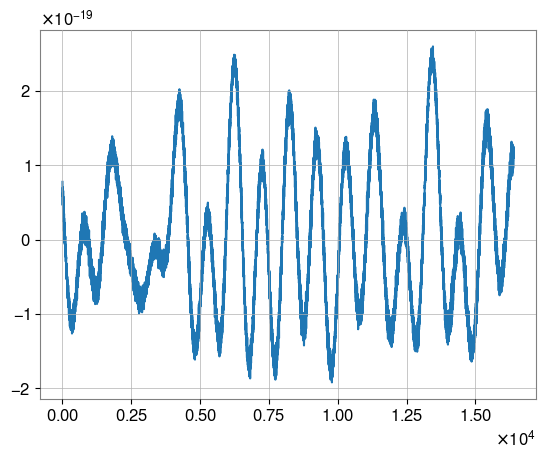

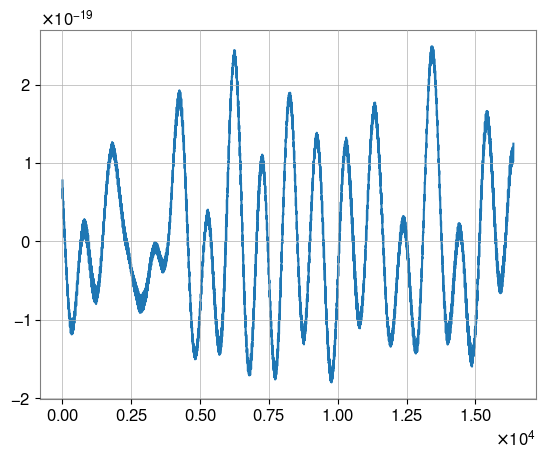

In [34]:
plt.figure()
plt.plot(tt)
plt.show()

n = 60
factor = ts.sample_rate.value/4096
filt = firwin(n+1, 1./factor, window="hamming")
# print(filt)
b, a = filt, [1.]
x = filtfilt(b, a, tt)
plt.figure()
plt.plot(x)
plt.show()

<class 'gwpy.timeseries.timeseries.TimeSeries'>
<class 'numpy.ndarray'>
[7.76602057e-20 6.88833644e-20 6.91179947e-20 ... 1.24739219e-19
 1.09028871e-19 1.24573688e-19]


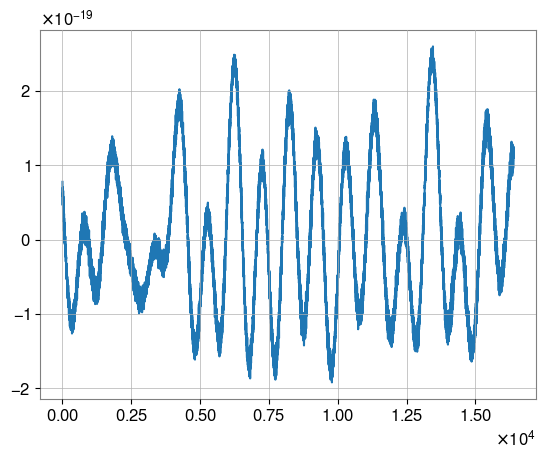

[9.17024795e-20 6.02864053e-20 5.67847379e-20 ... 1.02822070e-19
 1.03380028e-19 1.17273768e-19]


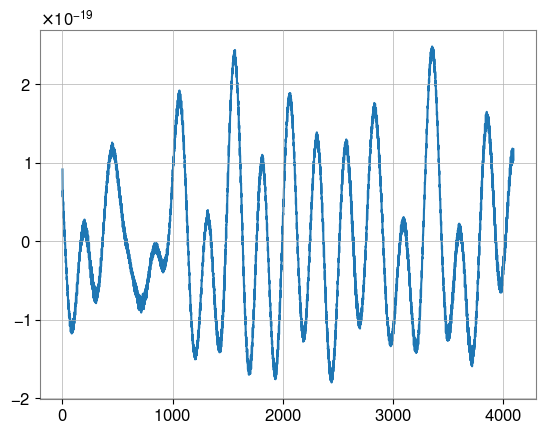

In [37]:
print(ts.__class__)
print(tt.__class__)
print(tt)
plt.figure()
plt.plot(tt)
plt.show()

nsamp = int(1*4096)
new = resample(tt, nsamp, window="hamming")

print(new)
plt.figure()
plt.plot(new)
plt.show()

In [36]:
# window = hann(40)[:20]
# plt.figure()
# plt.plot(window[::-1])
# plt.show()

In [38]:
# FrameCrawler
hoft_dir = "/home/chiajui.chou/ll_data_O4_review/kafka/H1"
witness_dir = "/home/chiajui.chou/ll_data_O4_review/lldetchar/H1"
hoft_crawler = FrameCrawler(Path(hoft_dir))
witness_crawler = FrameCrawler(Path(witness_dir))
# channels
witness_channels = sorted(witness_channels)
channels = [strain_channel] + witness_channels
# sample_rate
sample_rate = 4096

In [39]:
def frame_it(hoft_crawler, witness_crawler, channels: Iterable[str], sample_rate: float):
    strain, *witnesses = channels
    buffers = {i: Buffer(sample_rate) for i in channels}
    fname_buffer = None
    i = 0
    for strain_fname, witness_fname in zip(hoft_crawler, witness_crawler):
        if i < 2:
            i += 1
            continue

        if not witness_fname.exists():
            #logger.warning
            print(
                "Witness frame {} was dropped, attempting "
                "to load corresponding strain frame {}".format(
                    witness_fname, strain_fname
                )
            )
        else:
            #logger.debug
            #print(
            #    f"Loading frame files {witness_fname}, {strain_fname}"
            #)
            pass 

        y = buffers[strain].update(strain_fname, strain)
        X = []
        for channel in witnesses:
            # if the buffer update returned a frame that's
            # been resampled and is ready for use, append it
            x = buffers[channel].update(witness_fname, channel)

            if x is not None:
                X.append(x)
                yield fname_buffer, y, X

        # if all our buffers returned usable data,
        # concatenate them into a single array and
        # return it along with the strain filename
        # and associated data
        if len(X) == len(witnesses):
            X = np.stack(X)

        # update our strain filename buffer to
        # represent the current filename
        fname_buffer = strain_fname

In [45]:
frame_iterator = frame_it(
    hoft_crawler,
    witness_crawler,
    channels,
    sample_rate,
)

In [46]:
for i in range(21):
    print(next(iter(frame_iterator)))

(PosixPath('/home/chiajui.chou/ll_data_O4_review/kafka/H1/H-H1_llhoft-1250921169-1.gwf'), array([ 1.15276801e-20,  1.02201674e-20,  8.83640435e-21, ...,
       -1.70701224e-19, -1.68452895e-19, -1.69335923e-19]), [array([-15.327625 , -15.328796 , -15.329971 , ...,  -4.3375816,
        -4.360871 ,  -4.3841534], dtype=float32)])
(PosixPath('/home/chiajui.chou/ll_data_O4_review/kafka/H1/H-H1_llhoft-1250921169-1.gwf'), array([ 1.15276801e-20,  1.02201674e-20,  8.83640435e-21, ...,
       -1.70701224e-19, -1.68452895e-19, -1.69335923e-19]), [array([-15.327625 , -15.328796 , -15.329971 , ...,  -4.3375816,
        -4.360871 ,  -4.3841534], dtype=float32), array([ 7.3799124,  7.3342695,  7.2886267, ..., 43.11363  ,
       43.140602 , 43.16761  ], dtype=float32)])
(PosixPath('/home/chiajui.chou/ll_data_O4_review/kafka/H1/H-H1_llhoft-1250921169-1.gwf'), array([ 1.15276801e-20,  1.02201674e-20,  8.83640435e-21, ...,
       -1.70701224e-19, -1.68452895e-19, -1.69335923e-19]), [array([-15.327625 , 